In [2790]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from os import listdir

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve


from main import df_scrolling_object

import my_func
import importlib
# importlib.reload(main)
importlib.reload(my_func)

from pandas_profiling import ProfileReport

In [2791]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [2792]:
input_folder = 'input/'
listdir(input_folder)

[&#39;train.csv&#39;]

| Столбец        |     Значение                    |
|:---------------|:--------------------------------|
|client_id	     |    идентификатор клиента        |  
|education	     |   уровень образования           | 
|sex	         | пол заёмщика  
|age             |	возраст заёмщика  
|car	         |флаг наличия автомобиля  
|car_type	     |флаг автомобиля-иномарки  
|decline_app_cnt |	количество отказанных прошлых заявок  
|good_work       |	флаг наличия «хорошей» работы  
|bki_request_cnt |	количество запросов в БКИ  
|home_address	 |категоризатор домашнего адреса  
|work_address	 |категоризатор рабочего адреса  
|income	         |доход заёмщика  
|foreign_passport|	наличие загранпаспорта  
|sna | связь заемщика с клиентами банка
|first_time | давность наличия информации о заемщике
|score_bki | скоринговый балл по данным из БКИ
|region_rating | рейтинг региона
|app_date | дата подачи заявки
|default	     |наличие дефолта  

In [2793]:
data_train = pd.read_csv('kaggle/train.csv')
data_subm = pd.read_csv('kaggle/sample_submission.csv')
data_test = pd.read_csv('kaggle/test.csv')
data_train['train'] = 1 # помечаем где у нас трейн
data_test['train'] = 0 # помечаем где у нас тест
data = data_train.append(data_test, sort=False).reset_index(drop=True)

In [2794]:
bin_cols = ['good_work', 'foreign_passport', 'car', 'car_type', 'sex' ]
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
cat_cols = ['education', 'home_address' , 'work_address', 'first_time', 'sna' , 'region_rating']
(bin_cols + num_cols + cat_cols)

[&#39;good_work&#39;,
 &#39;foreign_passport&#39;,
 &#39;car&#39;,
 &#39;car_type&#39;,
 &#39;sex&#39;,
 &#39;age&#39;,
 &#39;decline_app_cnt&#39;,
 &#39;bki_request_cnt&#39;,
 &#39;income&#39;,
 &#39;score_bki&#39;,
 &#39;education&#39;,
 &#39;home_address&#39;,
 &#39;work_address&#39;,
 &#39;first_time&#39;,
 &#39;sna&#39;,
 &#39;region_rating&#39;]

In [2795]:
# переведем признак data.score_bki к положительным значениям, чтобы проще можно было логорифмировать
data.score_bki = data.score_bki - data.score_bki.min() 

In [2796]:
data.groupby('education').income.mean().sort_values(ascending=True)

education
SCH    32033.254681
UGR    39009.904868
GRD    54315.008916
PGR    79753.214477
ACD    85949.405498
Name: income, dtype: float64

In [2797]:
edu_income_rel = dict({'SCH': list([0, 31960.275039]),
                       'UGR': list([31960.275039,39391.796251]),
                       'GRD': list([39391.796251, 54663.948941]),
                       'PGR': list([54663.948941, 77548.206046]),
                       'ACD': list([77548.206046, 999999999999])})
def fill_edu(income, edu_income_rel):
    for edu, income_edu in edu_income_rel.items():
         if income_edu[0] < income <  income_edu[1]:
             return edu

na_index = data[data.education.isna()].index

# data['education_isNAN'] = pd.isna(data.education).astype('uint8')
data.loc[data['education'].isna(), 'education'] = data[data.education.isna()].income.apply(lambda x: fill_edu(x, edu_income_rel))
# for index in na_index:
#     inc = data.income.iloc[index]
#     data.education.iloc[index] = fill_edu(inc, edu_income_rel)
# data[data.education.isna()].education = data[data.education.isna()].income.apply(lambda x: fill_edu(x, edu_income_rel))


### Собираем дату

In [2798]:
data.app_date = pd.to_datetime(data.app_date)
data['month'] = data.app_date.dt.month
data['day'] = data.app_date.dt.day
data['year'] = data.app_date.dt.year

last_date = set()
data['app_date_diff_today'] = pd.datetime.today() - data.app_date
data['app_date_diff_today'] = data['app_date_diff_today'].dt.days

data.drop(['app_date'], axis=1, inplace=True)


# ВЫБРОСЫ !!!!!!!   
Все нумерные признаки оставляем с выбросами, как таковые выбросы были   
обнаружены в колонке дохода, но для любого сокращенного диапазона по этому признаку   
скор падает

In [2799]:
data[data.default==0].score_bki.mean()

1.6865381729461284

In [2800]:
data[data.default==1].score_bki.mean()

1.948949209981858

# Образование

In [2801]:
# data.groupby('default')['education'].hist()
# print(data.education.value_counts())

edu_dict = dict({'SCH': 0, #school
                 'GRD': 1, #out-student
                 'UGR': 2, #student
                 'PGR': 3, #aspirant
                 'ACD': 4})#academic 

# data['education_lvl'] = data['education'].map(edu_dict)
# data['education'] = data['education'].map(edu_dict)
# data['education'] = data['education'].astype('category').cat.codes#
data['education'] = data['education'].map(edu_dict)
# data.groupby(by='education').code_education.mean()

In [2802]:
data['education']

0         0
1         0
2         0
3         0
4         1
         ..
110143    0
110144    1
110145    1
110146    2
110147    0
Name: education, Length: 110148, dtype: int64

In [2803]:
# data.groupby('default')['car_type'].mean()

# PROFILER

In [2804]:
# profile = ProfileReport(data)
# profile.to_widgets()

# ГЕНЕРИРУЕМ !!!!!!!!!!

In [2805]:
data.groupby(by='education').default.mean().sort_values()


education
4    0.040179
3    0.064692
1    0.090114
2    0.131309
0    0.150593
Name: default, dtype: float64

In [2806]:
label_encoder = LabelEncoder()

for bin_col in bin_cols:
    data[bin_col] = label_encoder.fit_transform(data[bin_col])
# data['money_home_car'] = data['income'] - data['home_address'] * 1000 - data['car'] * 1000 - data['car_type'] * 1000
# data[bin_col]

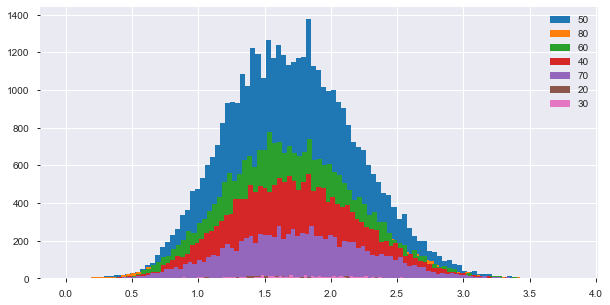

In [2807]:
# data['bki_on_power_count'] = data['']
# new_cols = ['bki_on_power_count']
# data[data.score_bki>3.5].sort_values(by='default')
plt.rcParams['figure.figsize'] = (10,5)


for region in data.region_rating.unique():
    data[(data.region_rating == region)].score_bki.hist(bins=100, label=region)
    plt.legend()

&lt;AxesSubplot:xlabel=&#39;region_rating&#39;&gt;

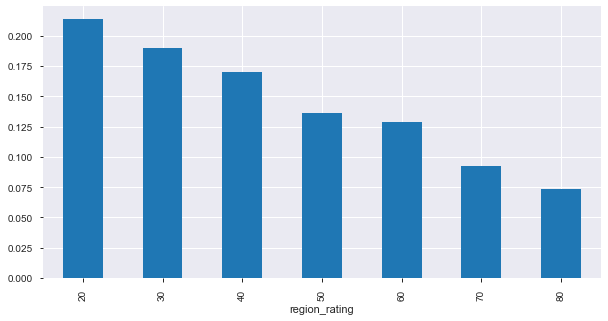

In [2808]:
for_plot = data.groupby(by='region_rating')['default'].mean()
for_plot.plot.bar()

&lt;AxesSubplot:xlabel=&#39;income,good_work&#39;&gt;

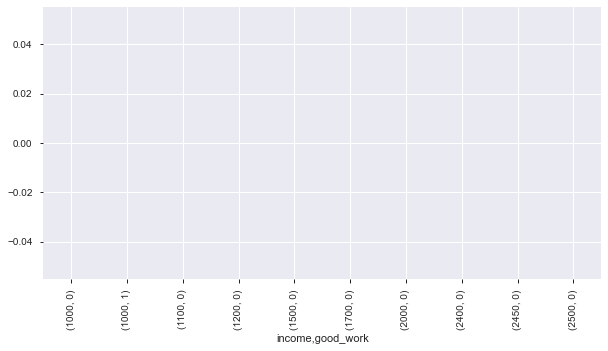

In [2809]:
for_plot = data.groupby(by=['income','good_work'])['default'].mean()
for_plot.head(10).plot.bar()
# for_plot

&lt;AxesSubplot:xlabel=&#39;first_time&#39;&gt;

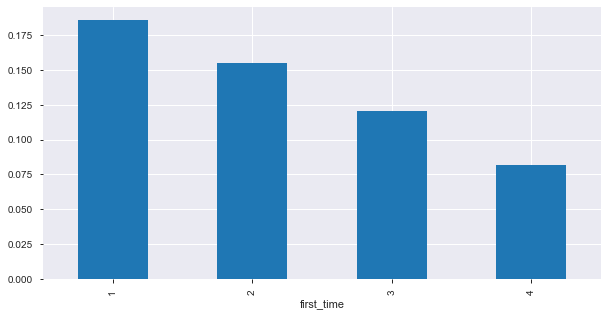

In [2810]:
for_plot = data.groupby(by='first_time')['default'].mean()
for_plot.plot.bar()

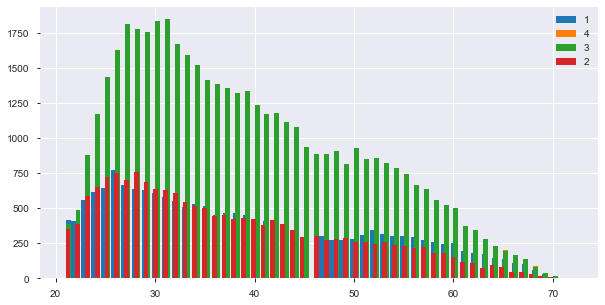

In [2811]:
for first_time in data.first_time.unique():
    data[(data.first_time == first_time)].age.hist(bins=100, label=first_time)
    plt.legend()

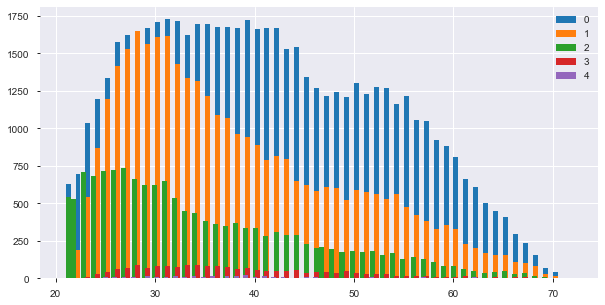

In [2812]:
for first_time in data.education.unique():
    data[(data.education == first_time)].age.hist(bins=100, label=first_time)
    plt.legend()

# НОВЫЕ!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [2813]:
data['region_firstt'] = data['region_rating'] / (data['first_time'])
data['age_first'] = data['age'] - data['first_time'] 
data['sna_age'] =  data['age'] * data['sna'] 

data['age_eduaction'] = data['age'] / (data['education']+1 )
data['age_foreign_pass'] = data['age'] / data['foreign_passport'].apply(lambda x: 1/1.1 if x==1 else 1.1)
# data['age_car_type '] = data['age'] / data['car_type'].apply(lambda x: 1/1.2 if x==1 else 1.2)
data['age_good_work '] = data['age'] / data['good_work'].apply(lambda x: 1/1.2 if x==1 else 1.2)


# data['good_job_on_age'] = 
# data['income_by_sna'] = data['income'] / data['sna']
# data['bki_to_count'] = data['score_bki'] / (data['bki_request_cnt'] + 0.01)

new_cols = ['sna_age']
# добавим новый признак к списку категорий, чтобы он попал на логарифмирование и стандартизацию
num_cols = num_cols + ['region_firstt'] #+ ['sna_age']

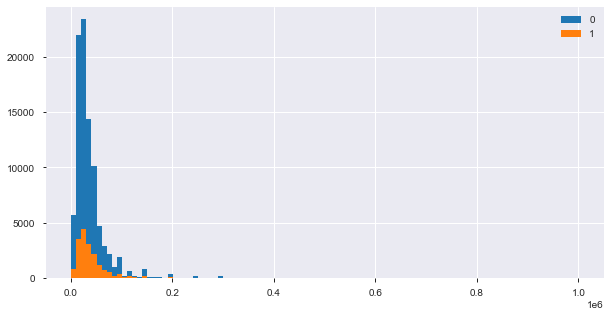

In [2814]:
for good_work  in data.good_work.unique():
    data[(data.good_work  == good_work )].income.hist(bins=100, label=good_work )
    plt.legend()

In [2815]:
data.income

0          18000
1          19000
2          30000
3          10000
4          30000
           ...  
110143     15000
110144    200000
110145     60000
110146     30000
110147     15000
Name: income, Length: 110148, dtype: int64

# ПОИСК !! ПОИСК !! ПОИСК !! ПОИСК ПОИСК !!ПОИСК !!ПОИСК !! ПОИСК !! ПОИСК !! ПОИСК !! ПОИСК ПОИСК !!ПОИСК !!ПОИСК !!ПОИСК !! ПОИСК !! ПОИСК !! ПОИСК ПОИСК !!ПОИСК !!ПОИСК !!ПОИСК !! ПОИСК !! ПОИСК !! ПОИСК ПОИСК !!ПОИСК !!ПОИСК !!

In [2816]:
# data_train = pd.read_csv('kaggle/train.csv')
# data_test = pd.read_csv('kaggle/test.csv')
# data_train['train'] = 1 # помечаем где у нас трейн
# data_test['train'] = 0 # помечаем где у нас тест
# data = data_train.append(data_test, sort=False).reset_index(drop=True)
# bin_cols = ['good_work', 'foreign_passport', 'car', 'car_type', 'sex' ]
# num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
# cat_cols = ['education', 'home_address' , 'work_address', 'first_time', 'sna' , 'region_rating']
# data.score_bki = data.score_bki - data.score_bki.min() 
# edu_income_rel = dict({'SCH': list([0, 31960.275039]),
#                        'UGR': list([31960.275039,39391.796251]),
#                        'GRD': list([39391.796251, 54663.948941]),
#                        'PGR': list([54663.948941, 77548.206046]),
#                        'ACD': list([77548.206046, 999999999999])})
# def fill_edu(income, edu_income_rel):
#     for edu, income_edu in edu_income_rel.items():
#          if income_edu[0] < income <  income_edu[1]:
#              return edu
# na_index = data[data.education.isna()].index
# data['education_isNAN'] = pd.isna(data.education).astype('uint8')
# for index in na_index:
#     inc = data.income.iloc[index]
#     data.education.iloc[index] = fill_edu(inc, edu_income_rel)

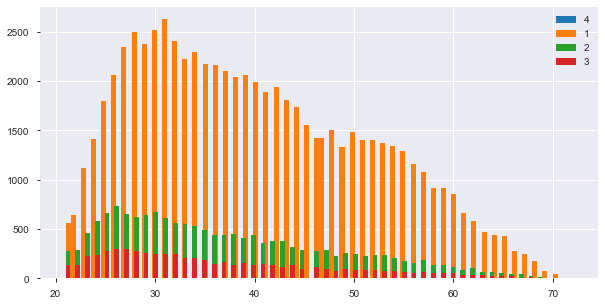

In [2817]:
for sna in data.sna.unique():
    data[(data.sna == sna)].age.hist(bins=100, label=sna)
    plt.legend()

# возраст + херовая работа  
# возраст + нет образования

In [2818]:
print('NUM ', num_cols, '\n', 'CAT ', cat_cols)

NUM  [&#39;age&#39;, &#39;decline_app_cnt&#39;, &#39;bki_request_cnt&#39;, &#39;income&#39;, &#39;score_bki&#39;, &#39;region_firstt&#39;] 
 CAT  [&#39;education&#39;, &#39;home_address&#39;, &#39;work_address&#39;, &#39;first_time&#39;, &#39;sna&#39;, &#39;region_rating&#39;]


,sna,income,default,age
0,1,43881.758761,0.098201,40.061502
1,2,38947.063290,0.149821,37.005558
2,3,35688.846441,0.157652,36.320929
3,4,33156.887649,0.211507,39.029003


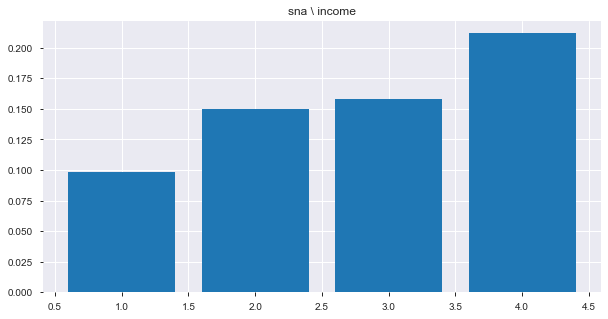

In [2819]:
for_plot = data.groupby(by=['sna'])['income', 'default', 'age'].mean().reset_index()
# for_plot['car_type'] =  for_plot['car_type'] + for_plot['car']
plt.bar(x=for_plot.sna, height=for_plot.default)
plt.title('sna \ income')
for_plot

In [2820]:
# data['bki_to_count'].sort_values(ascending=False)
# data.drop(index=34773, inplace=True)

# EDA

In [2821]:
for_plot = data.groupby(by='car_type')['default'].mean()
# for_plot.foreign_passport.plot.bar()
# for_plot.income.plot.bar()
for_plot

car_type
0    0.136258
1    0.087450
Name: default, dtype: float64

,age,decline_app_cnt,bki_request_cnt,income,score_bki,region_firstt
default,,,,,,
0.0,39.390504,0.240877,1.933134,41799.713288,1.686538,24.875647
1.0,38.525395,0.515472,2.462335,36288.113316,1.948949,27.551216


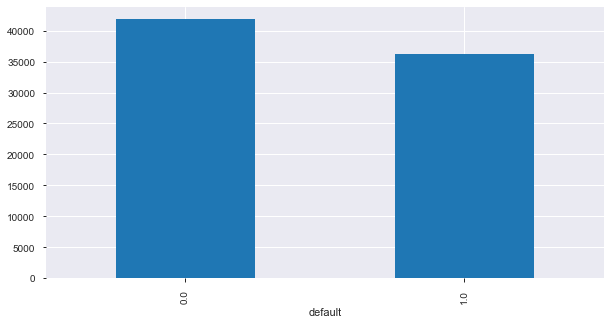

In [2822]:
for_plot = data.groupby(by='default')[num_cols].mean()
for_plot.age.plot.bar()
for_plot.income.plot.bar()
for_plot

&lt;AxesSubplot:xlabel=&#39;bki_request_cnt&#39;&gt;

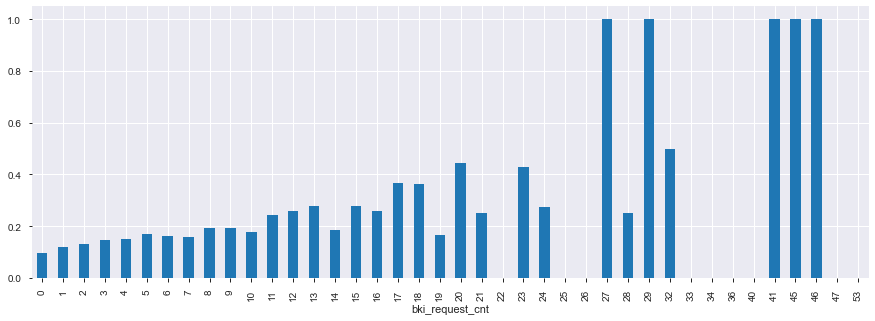

In [2823]:
plt.figure(figsize=(15,5))
data.groupby('bki_request_cnt').default.mean().plot.bar()


# Корреляция. 
### Зависимости между признаками наблюдаются, однако отсеивание по   
### данному критерию негативно влияет на модель

## Рассмотрим зависимости между некоторыми параметрами в связи с целевым.
## дефолт \ марка машины

,car_type,income,default
0,no car,33153.865554,0.136960
1,common car,40058.143367,0.132744
2,foreign car,69478.156417,0.087450


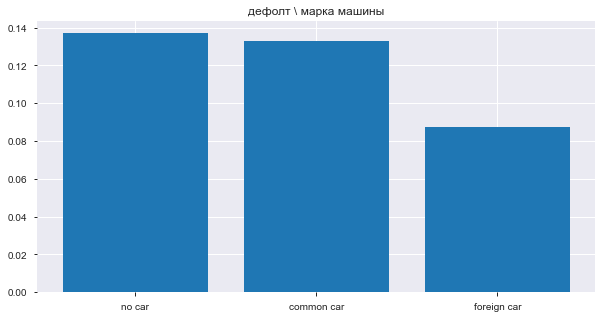

In [2824]:
for_plot = data.groupby(by=['car_type', 'car'])['income', 'default'].mean().reset_index()
for_plot['car_type'] =  for_plot['car_type'] + for_plot['car']
for_plot.car_type = for_plot.car_type.apply(lambda x: 'no car' if x==0 else 
                                                      'common car' if x==1 else 
                                                      'foreign car')
for_plot.drop('car', axis=1, inplace=True)

plt.bar(x=for_plot.car_type, height=for_plot.default)
plt.title('дефолт \ марка машины')
for_plot

## доход \ марка машины

Text(0.5, 1.0, &#39;доход \\ марка машины&#39;)

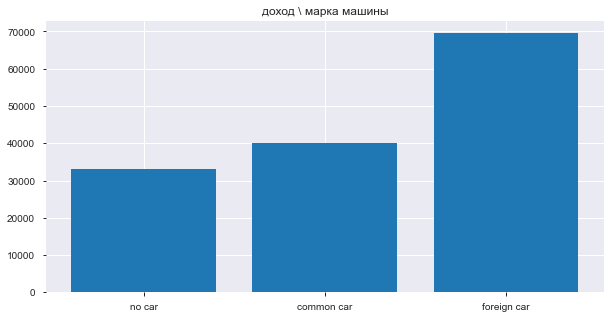

In [2825]:
plt.bar(x=for_plot.car_type, height=for_plot.income)
plt.title('доход \ марка машины')

Вывод: с господами с иномарками реже случается дефолт, так же они в среднем довольно больше зарабатывают

Text(0.5, 1.0, &#39;доход \\ категория домашнего адреса&#39;)

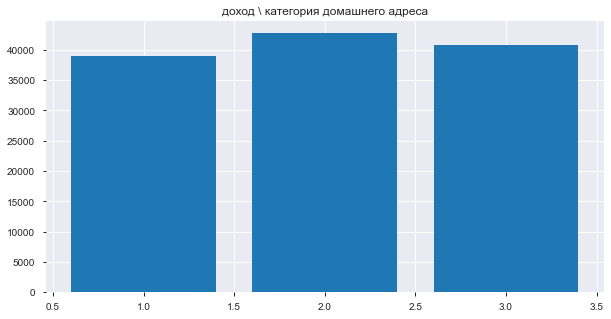

In [2826]:
for_plot = data.groupby(by=['home_address'])['income', 'default'].mean()
plt.bar(x=for_plot.index, height=for_plot.income)
plt.title('доход \ категория домашнего адреса')

Text(0.5, 1.0, &#39;дефолт \\ категория домашнего адреса&#39;)

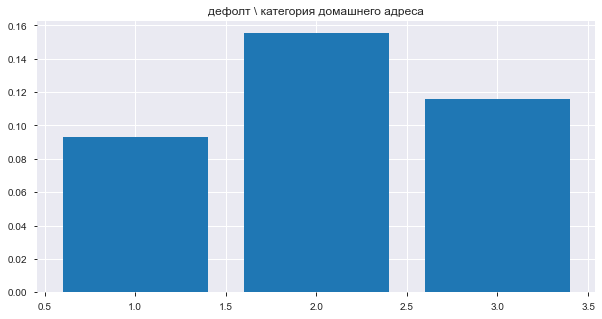

In [2827]:
plt.bar(x=for_plot.index, height=for_plot.default)
plt.title('дефолт \ категория домашнего адреса')

Вывод: Дефолтные юниты проживающие во второй категории встречаются чаще.

# Определение важности признаков

&lt;AxesSubplot:&gt;

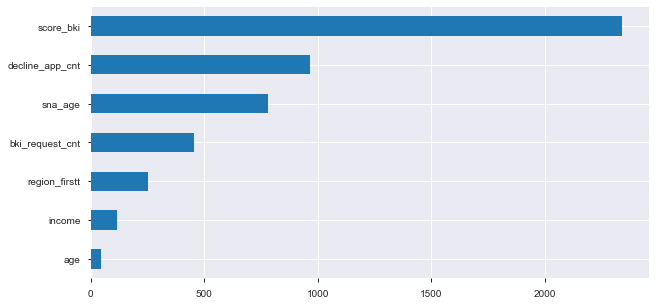

In [2828]:
data_num = data[data.train==1].copy()
imp_num = Series(f_classif(data_num[num_cols + new_cols], data_num['default'])[0], index = num_cols + new_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [2829]:
label_encoder = LabelEncoder()

for bin_col in bin_cols:
    data[bin_col] = label_encoder.fit_transform(data[bin_col])

# data.education = data.education.astype('category').cat.codes

&lt;AxesSubplot:&gt;

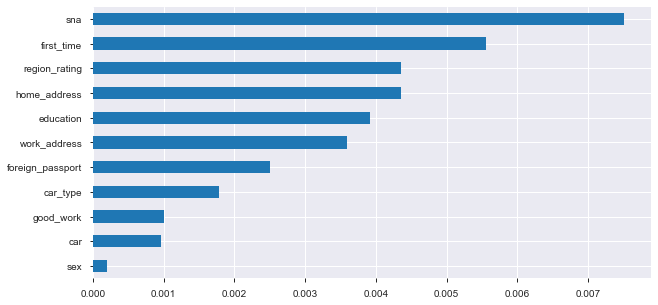

In [2830]:
data_cat = data[data.train==1].copy()
imp_cat = Series(mutual_info_classif(data_cat[bin_cols + cat_cols], data_cat['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [2831]:
data = pd.get_dummies(data, columns=cat_cols, drop_first=False)

In [2832]:
cat_cols

[&#39;education&#39;,
 &#39;home_address&#39;,
 &#39;work_address&#39;,
 &#39;first_time&#39;,
 &#39;sna&#39;,
 &#39;region_rating&#39;]

In [2833]:
data[num_cols] = data[num_cols].apply(lambda x: np.log(x + 1))

In [2834]:
# Стандартизация числовых переменных

data[num_cols] = StandardScaler().fit_transform(data[num_cols].values)

In [2835]:
import main
from main import df_scrolling_object
import importlib
importlib.reload(main)

# data_obj = df_scrolling_object(data)
# X, Y = data_obj.return_XY()

X = data[data.train==1].drop(['default'], axis=1)
Y = data[data.train==1]['default']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

Лучшее Penalty: l1
Лучшее C: 1.0
Лучшее Solver: liblinear

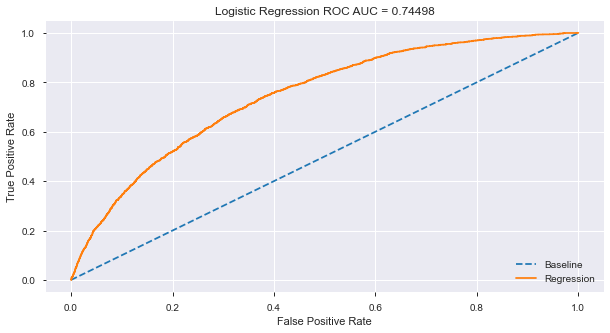

roc_auc=0.744978  C=1   penalty=l1 solver=liblinear
[[12878    55]
 [ 1788    39]]


In [2836]:
# C = 1
# penalty = 'l2'
# solver = 'newton-cg'

C = 1
penalty = 'l1'
solver = 'liblinear'

model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
print(confusion_matrix(y_test, y_pred))

In [2837]:
# X_test = data[data.train==0].drop('default', axis=1)
# y_pred_subm = model.predict_proba(X_test)[:,1]

# submit = pd.DataFrame(X_test.client_id)
# submit['default'] = y_pred_subm
# submit.to_csv('submission.csv', index=False)

roc_auc=0.744978  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744955  C=1   penalty=l1 solver=liblinear  + age ~ foreign pass(1.1)  
roc_auc=0.744949  C=1   penalty=l1 solver=liblinear  + age ~ foreign pass(1.2)  
roc_auc=0.744922  C=1   penalty=l1 solver=liblinear  + age ~ foreign pass(1.4)  
roc_auc=0.744845  C=1   penalty=l1 solver=liblinear  + age/ edu  nonlog  
roc_auc=0.744803  C=1   penalty=l1 solver=liblinear  + age* edu  nonlog  
roc_auc=0.744673  C=1   penalty=l1 solver=liblinear  + sna*age  nonlog  
roc_auc=0.744571  C=1   penalty=l1 solver=liblinear  + sna/age  nonlog  
roc_auc=0.744213  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744213  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744709  C=1   p enalty=l2 solver=newton-cg  
roc_auc=0.744682  C=1   penalty=l2 solver=newton-cg  
roc_auc=0.744641  C=1   penalty=l2 solver=newton-cg   
roc_auc=0.744112 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.744088 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.743984 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.7439 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.743433 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.677348  
roc_auc=0.677304  
roc_auc=0.677311 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.677277 C=2.7825594022071245 penalty=l2 solver=  

In [2838]:
# from sklearn.model_selection import GridSearchCV
# # Добавим типы регуляризации
# penalty = ['l1', 'l2']
# # Зададим ограничения для параметра регуляризации
# C = np.logspace(0, 4, 10)
# # solver
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# # Score
# scoring = {'AUC': 'roc_auc'}

# # Добавим типы регуляризации
# iter_ = 50
# epsilon_stop = 1e-3

# # Создадим гиперпараметры
# # hyperparameters = dict(C=C, penalty=penalty, solver=solver)

# hyperparameters = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs', 'newton-cg'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]

# model = LogisticRegression()
# # model.fit(X_train, y_train)

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0,  scoring=scoring, refit='AUC')

# best_model = clf.fit(X_train, y_train)

# # View best hyperparameters
# print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
# print('Лучшее Solver:', best_model.best_estimator_.get_params()['solver'])

In [2839]:
# y_best_prob = best_model.predict_proba(X_test)

# probs = y_best_prob[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))

In [2840]:
# from sklearn.feature_selection import RFE


# estimator = LogisticRegression(C=C, penalty=penalty, solver = solver)
# selector = RFE(estimator, n_features_to_select=40, step=1)
# selector = selector.fit(X, Y)
# true_features_mask = selector.support_
# X = selector.transform(X)

In [2841]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

In [2842]:
# # Добавим 
# iter_ = 50
# epsilon_stop = 1e-3

# # Создадим гиперпараметры
# hyperparameters = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]

# model = LogisticRegression()

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, scoring='f1', cv=5, verbose=0, refit='f1')

# clf.fit(X_train, y_train)
# model_2 = clf.best_estimator_

# # View best hyperparameters
# print('Лучшее Penalty:', model_2.get_params()['penalty'])
# print('Лучшее C:', model_2.get_params()['C'])
# print('Лучшее Solver:', model_2.get_params()['solver'])

In [2843]:
# y_best_prob = model_2.predict_proba(X_test)

# probs = y_best_prob[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))

Лучшее Penalty: l1
Лучшее C: 1291.5496650148827
Лучшее Solver: liblinear

In [2844]:
# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer  



# from sklearn.metrics import make_scorer
# from sklearn.metrics import accuracy_score, f1_score
# scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(f1_score)}
# hyperparameters = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]
# # Setting refit='AUC', refits an estimator on the whole dataset with the
# # parameter setting that has the best cross-validated AUC score.
# # That estimator is made available at ``gs.best_estimator_`` along with
# # parameters like ``gs.best_score_``, ``gs.best_params_`` and
# # ``gs.best_index_``
# model = LogisticRegression()

# gs = GridSearchCV(model,
#                   param_grid=hyperparameters,
#                   scoring=scoring, refit='AUC', return_train_score=True)
# gs.fit(X_train, y_train)

# results = gs.cv_results_
# model_3 = gs.best_estimator_

In [2845]:
# print('Лучшее Penalty:', gs.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', gs.best_estimator_.get_params()['C'])
# print('Лучшее Solver:', gs.best_estimator_.get_params()['solver'])

In [2846]:
# model_3 = gs.best_estimator_

In [2847]:
# y_best_prob = model_3.predict_proba(X_test)

# probs = y_best_prob[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))

In [2848]:
# plt.figure(figsize=(13, 13))
# plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
#           fontsize=16)

# plt.xlabel("min_samples_split")
# plt.ylabel("Score")

# ax = plt.gca()
# ax.set_xlim(0, 402)
# ax.set_ylim(0.73, 1)

# # Get the regular numpy array from the MaskedArray
# X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

# for scorer, color in zip(sorted(scoring), ['g', 'k']):
#     for sample, style in (('train', '--'), ('test', '-')):
#         sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
#         sample_score_std = results['std_%s_%s' % (sample, scorer)]
#         ax.fill_between(X_axis, sample_score_mean - sample_score_std,
#                         sample_score_mean + sample_score_std,
#                         alpha=0.1 if sample == 'test' else 0, color=color)
#         ax.plot(X_axis, sample_score_mean, style, color=color,
#                 alpha=1 if sample == 'test' else 0.7,
#                 label="%s (%s)" % (scorer, sample))

#     best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
#     best_score = results['mean_test_%s' % scorer][best_index]

#     # Plot a dotted vertical line at the best score for that scorer marked by x
#     ax.plot([X_axis[best_index], ] * 2, [0, best_score],
#             linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

#     # Annotate the best score for that scorer
#     ax.annotate("%0.2f" % best_score,
#                 (X_axis[best_index], best_score + 0.005))

# plt.legend(loc="best")
# plt.grid(False)
# plt.show()

In [2849]:
# X_test = data[data.train==0].drop('default', axis=1)
# y_pred_subm = model.predict_proba(X_test)[:,1]

# submit = pd.DataFrame(X_test.client_id)
# submit['default'] = y_pred_subm
# submit.to_csv('submission.csv', index=False)